In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Paths to train, val, and test directories
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

# Load each set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


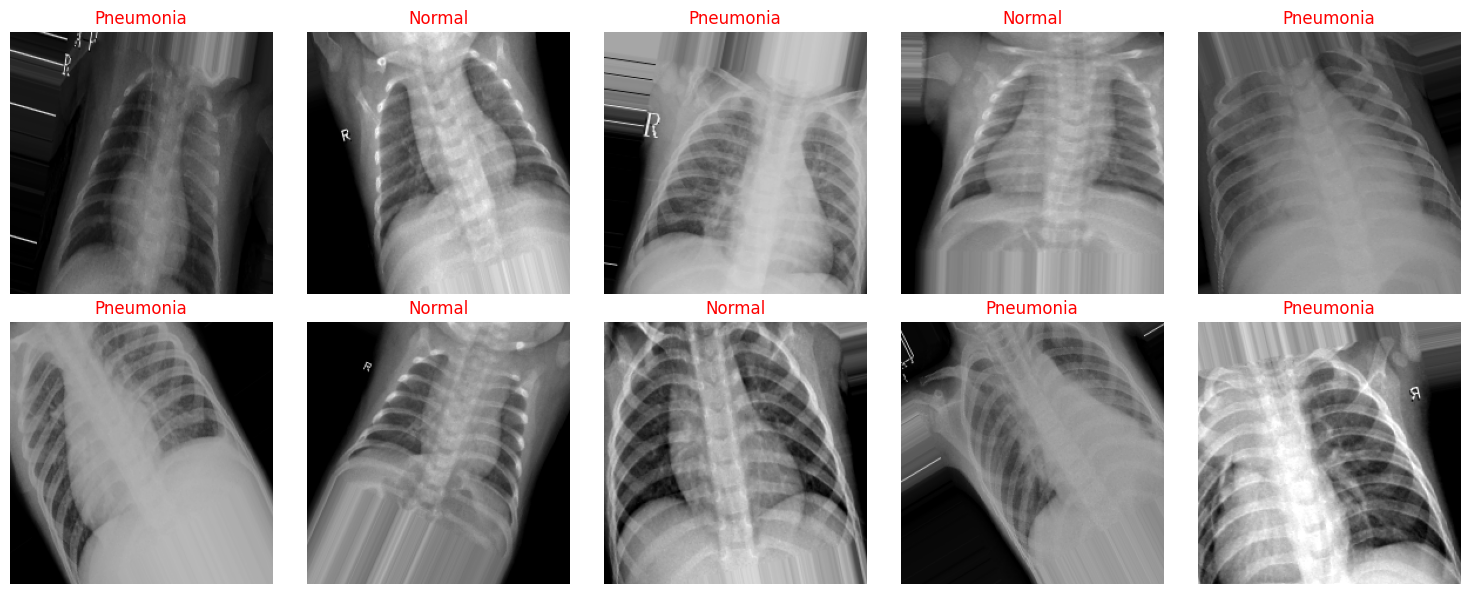

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
image_batch, label_batch = next(train_generator)

# Number of images to display
num_images = 10

# Iterate over the batch and plot each image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(num_images):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image_batch[i])
    axes[row, col].axis('off')
    
    # Display label (0 or 1), where 0 might indicate 'Normal' and 1 'Pneumonia'
    label = label_batch[i]
    class_name = 'Normal' if label == 0 else 'Pneumonia'
    axes[row, col].set_title(class_name, color='red')

plt.tight_layout()
plt.show()
